# Advanced pyALF part 2: Postprocessing

In [1]:
from py_alf import utils

In [2]:
# Change some Matplotlib defaults for nicer figures
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [5, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["xtick.direction"] = 'in'
mpl.rcParams["ytick.direction"] = 'in'
mpl.rcParams["xtick.top"] = True
mpl.rcParams["ytick.right"] = True
mpl.rcParams["figure.constrained_layout.use"] = True

In [3]:
dirs = utils.find_sim_dirs()
dirs

['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_2',
 '

## Custom observables

In [4]:
import numpy as np

Correlation ratio 
$1 - \frac{O(\boldsymbol{k}+\boldsymbol{\delta})}{\boldsymbol{k}}$. RG-invariant quantity

In [5]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt,
        ks=((0., 0.),), mat=None, NNs=((1, 0), (0, 1), (-1, 0), (0, -1))):
    """RG-invariant quantity derived from a correlation function.

    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for NN in NNs:
            i = latt.nnlistk[n, NN[0], NN[1]]
            J2 += (obs[..., i].sum(axis=-1) * mat).sum() / len(NNs)
        out += (1 - J2/J1)

    return out / len(ks)

Binder cumulant $\left(3 - \frac{\langle s^4 \rangle}{\langle s^2 \rangle^2}\right)/2$. RG-invariant quantity

In [6]:
def binder(obs, sign, N_obs):
    return (3 - obs[2] / obs[1]**2)/2 / sign

Susceptibility $\int_{0}^{\beta}\!\text{d}\tau\, C\left(\boldsymbol{k},\tau\right)$

In [7]:
def susceptibility(obs, back, sign, N_orb, N_tau, dtau, latt,
                   ks=([0., 0.],)):
    """Susceptibility of a time-displaced correlation function.

    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    out = 0
    for k in ks:
        n = latt.k_to_n(k)
        out += dtau*obs[..., n].trace().sum() / sign
    return out / len(ks)

In [8]:
custom_obs = {}

In [9]:
custom_obs['R_S']= {
    'needs': ['IsingZ_eq'],
    'function': R_k,
    'kwargs': {}
}

custom_obs['R_chi']= {
    'needs': ['IsingZT_tau'],
    'function': R_k,
    'kwargs': {}
}

custom_obs['B']= {
    'needs': ['m_scal'],
    'function': binder,
    'kwargs': {}
}

custom_obs['chi']= {
    'needs': ['IsingZT_tau'],
    'function': susceptibility,
    'kwargs': {}
}

## Check warmup and autocorrelation

In [10]:
# Enable Jupyter Widget support for matplotlib
%matplotlib widget

In [11]:
from py_alf import check_rebin, check_warmup

In [12]:
check_warmup(dirs, ['m_scal', 'ising_x_scal', 'R_S', 'B', 'chi'], custom_obs=custom_obs, gui='ipy')

In [13]:
check_rebin(dirs, ['m_scal', 'ising_x_scal', 'R_S', 'B', 'chi'], custom_obs=custom_obs, gui='ipy')

## Symmetrize correlation functions

In [14]:
from math import pi


# Define list of transformations (Lattice, i) -> new_i
# Default analysis will average over all listed elements
def sym_c2_0(latt, i): return i
def sym_c2_1(latt, i): return latt.rotate(i, pi)

symmetry = [sym_c2_0, sym_c2_1]

## Error analysis

In [15]:
from py_alf.analysis import analysis  # The function behind Simulation.analysis

In [16]:
for directory in dirs:
    analysis(directory, custom_obs=custom_obs, symmetry=symmetry, always=True)

### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']
Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau
IsingXT_tau
IsingZT_tau
### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']
Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram obs

custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq


Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq


Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq


Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq


Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau
IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau
IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau
IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau
IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_2 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_3 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8_beta=32.0_xi=0.25_h=2.5/Temp_0 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8_beta=32.0_xi=0.25_h=2.5/Temp_1 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8_beta=32.0_xi=0.25_h=2.5/Temp_2 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8_beta=32.0_xi=0.25_h=2.5/Temp_3 ###
/home/jschwab/pyALF/doc/source/examples
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']


custom B ['m_scal']
custom chi ['IsingZT_tau']


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau


IsingXT_tau


IsingZT_tau


In [17]:
from py_alf.ana import load_res  # The function behind Simulation.get_obs

In [18]:
res = load_res(dirs)

./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/T

In [19]:
res

,beta,dtau,global_h,global_j,global_type,ham_chem,ham_h,ham_j,ham_t,ham_xi,...,IsingXT_tauK_err,IsingXT_tauR,IsingXT_tauR_err,IsingXT_tau_lattice,IsingZT_tauK,IsingZT_tauK_err,IsingZT_tauR,IsingZT_tauR_err,IsingZT_tau_lattice,lattice
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0,40.0,0.1,3.0,1.0,b'',0.0,2.5,1.0,1.0,0.25,...,"[[0.018123045105055864, 0.020175668020098264, ...","[[-0.8709956795250026, -0.8674885489539408, -0...","[[0.00367022938534152, 0.0036804351914123336, ...","{'L1': [7.071067811865475, 7.071067811865475],...","[[0.3246714185454148, 0.34436528445388265, 0.3...","[[0.0020298997096270407, 0.0021711547380445116...","[[0.5769938595126232, 0.5771094571672313, 0.57...","[[0.0010096572078773802, 0.0009875752005555477...","{'L1': [7.071067811865475, 7.071067811865475],...","{'L1': [7.071067811865475, 7.071067811865475],..."
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1,40.0,0.1,3.0,1.0,b'',0.0,3.0,1.0,1.0,0.25,...,"[[0.020887536388625505, 0.0158678069982503, 0....","[[-1.3018778929968167, -1.3022563039844222, -1...","[[0.006946284662323807, 0.005081693818774606, ...","{'L1': [7.071067811865475, 7.071067811865475],...","[[0.45562419636599927, 0.49940636960594953, 0....","[[0.001303622919150273, 0.002229099105823068, ...","[[0.32065048810841523, 0.32229398447808993, 0....","[[0.002045976911486508, 0.0022309774422836657,...","{'L1': [7.071067811865475, 7.071067811865475],...","{'L1': [7.071067811865475, 7.071067811865475],..."
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2,40.0,0.1,3.0,1.0,b'',0.0,3.5,1.0,1.0,0.25,...,"[[0.019191796694362145, 0.009587141721227262, ...","[[-1.748736267398871, -1.7472255186786119, -1....","[[0.0023535890307957888, 0.003204148418781276,...","{'L1': [7.071067811865475, 7.071067811865475],...","[[0.5914785365629266, 0.6488826292096126, 0.73...","[[0.00237145526930074, 0.003317554325265579, 0...","[[0.03642073185440092, 0.03871707579863153, 0....","[[0.0017410635218904858, 0.0018074590942099916...","{'L1': [7.071067811865475, 7.071067811865475],...","{'L1': [7.071067811865475, 7.071067811865475],..."
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3,40.0,0.1,3.0,1.0,b'',0.0,4.0,1.0,1.0,0.25,...,"[[0.012679866344583776, 0.011507437943101351, ...","[[-1.8488625469074915, -1.8459034212197922, -1...","[[0.003655015627824464, 0.003531783055427419, ...","{'L1': [7.071067811865475, 7.071067811865475],...","[[0.6314319425648977, 0.6854212702694709, 0.78...","[[0.004121326915032677, 0.004388448712200596, ...","[[0.0024637865277252068, 0.004312457284371512,...","[[0.000766378152796786, 0.0008402244424945884,...","{'L1': [7.071067811865475, 7.071067811865475],...","{'L1': [7.071067811865475, 7.071067811865475],..."
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0,16.0,0.1,3.0,1.0,b'',0.0,2.5,1.0,1.0,0.25,...,"[[0.012430530657130014, 0.013041633776393098, ...","[[-0.7979520318516969, -0.74463192333634, -0.8...","[[0.005164404353033268, 0.005348330087096698, ...","{'L1': [2.82842712474619, 2.82842712474619], '...","[[0.3686494019417796, 0.43498761251296897, 0.3...","[[0.002266398817776254, 0.002860799014207764, ...","[[0.6265049590167228, 0.6493626477046951, 0.62...","[[0.0015816870712224004, 0.0014397683181747844...","{'L1': [2.82842712474619, 2.82842712474619], '...","{'L1': [2.82842712474619, 2.82842712474619], '..."
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1,16.0,0.1,3.0,1.0,b'',0.0,3.0,1.0,1.0,0.25,...,"[[0.012046523085068398, 0.0125028808501829, 0....","[[-1.1640188447514135, -1.1105364185095727, -1...","[[0.005870941393343261, 0.006017146712816769, ...","{'L1': [2.82842712474619, 2.82842712474619], '...","[[0.5434000670626247, 0.6878985252639979, 0.54...","[[0.0029786151628680524, 0.004172045432912875,...","[[0.4427146003998081, 0.489285823153611, 0.442...","[

## Plot order parameter

In [20]:
import matplotlib.pyplot as plt

Text(0, 0.5, '$S(\\boldsymbol{k}=0)$')

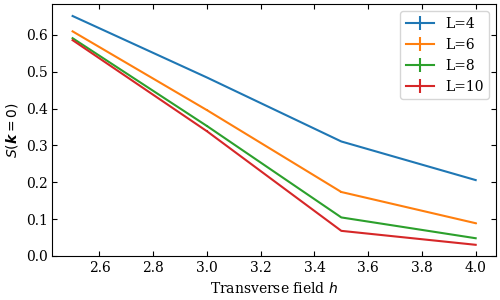

In [21]:
fig, ax = plt.subplots()
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    ax.errorbar(df.ham_h, df.m_scal0, df.m_scal0_err, label=f'L={L}')
ax.legend()
ax.set_xlabel('Transverse field $h$')
ax.set_ylabel(r'$S(\boldsymbol{k}=0)$')

## Plot RG-invariant quantities

RG-invariant quantities behave at critical point as:
$$
R = f(L^z/\beta, (h-h_c)L^{1/\nu}, L^{-\omega})
$$
Dismissing dependence on $\beta$ and finite size corrections:
$$
R = f((h-h_c)L^{1/\nu})
$$

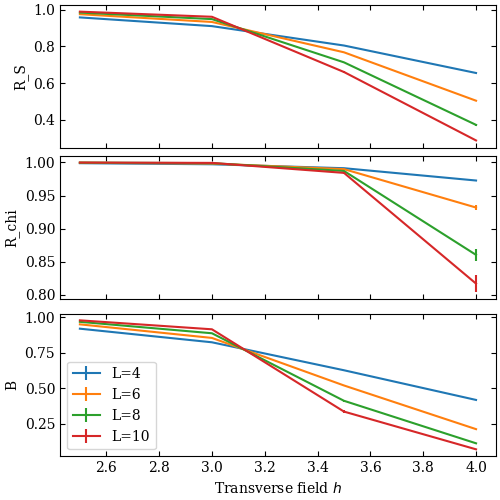

In [22]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(5,5), sharex=True)
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    for obs_name, ax in zip(['R_S', 'R_chi', 'B'],
                            axs.flat):
        ax.errorbar(df.ham_h, df[obs_name], df[obs_name+'_err'], label=f'L={L}')
        ax.set_ylabel(obs_name)
ax.set_xlabel('Transverse field $h$')
ax.legend();

## Attempting data collapse

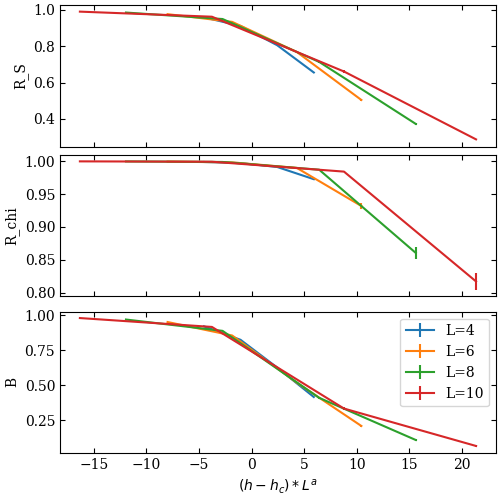

In [23]:
hc = 3.15
a = 1.4
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(5,5), sharex=True)
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    for obs_name, ax in zip(['R_S', 'R_chi', 'B'],
                            axs.flat):
        ax.errorbar((df.ham_h-hc)*L**a, df[obs_name], df[obs_name+'_err'], label=f'L={L}')
        ax.set_ylabel(obs_name)
ax.set_xlabel('$(h-h_c)*L^a$')
ax.legend();

## Plot correlation

### Accessing elements of the dataframe

In [24]:
for i in res:
    print(i)

beta
dtau
global_h
global_j
global_type
ham_chem
ham_h
ham_j
ham_t
ham_xi
ham_xi2
init_type
l1
l2
model_vers
n_sun
phi_1
phi_2
R_S
R_S_err
R_chi
R_chi_err
B
B_err
chi
chi_err
Acc_Temp_scal_sign
Acc_Temp_scal_sign_err
Acc_Temp_scal0
Acc_Temp_scal0_err
Kin_Pot_E_scal_sign
Kin_Pot_E_scal_sign_err
Kin_Pot_E_scal0
Kin_Pot_E_scal0_err
Kin_Pot_E_scal1
Kin_Pot_E_scal1_err
Kin_Pot_E_scal2
Kin_Pot_E_scal2_err
Part_scal_sign
Part_scal_sign_err
Part_scal0
Part_scal0_err
chi2_scal_sign
chi2_scal_sign_err
chi2_scal0
chi2_scal0_err
chi2_scal1
chi2_scal1_err
ising_x_alt_scal_sign
ising_x_alt_scal_sign_err
ising_x_alt_scal0
ising_x_alt_scal0_err
ising_x_scal_sign
ising_x_scal_sign_err
ising_x_scal0
ising_x_scal0_err
ising_z_alt_scal_sign
ising_z_alt_scal_sign_err
ising_z_alt_scal0
ising_z_alt_scal0_err
ising_z_scal_sign
ising_z_scal_sign_err
ising_z_scal0
ising_z_scal0_err
m_alt_scal_sign
m_alt_scal_sign_err
m_alt_scal0
m_alt_scal0_err
m_alt_scal1
m_alt_scal1_err
m_alt_scal2
m_alt_scal2_err
m_scal_sign

In [25]:
res.index

Index(['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nemati

In [26]:
item = res.loc['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0']
item

beta                                                                40.0
dtau                                                                 0.1
global_h                                                             3.0
global_j                                                             1.0
global_type                                                          b''
                                             ...                        
IsingZT_tauK_err       [[0.0020298997096270407, 0.0021711547380445116...
IsingZT_tauR           [[0.5769938595126232, 0.5771094571672313, 0.57...
IsingZT_tauR_err       [[0.0010096572078773802, 0.0009875752005555477...
IsingZT_tau_lattice    {'L1': [7.071067811865475, 7.071067811865475],...
lattice                {'L1': [7.071067811865475, 7.071067811865475],...
Name: ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0, Length: 126, dtype: object

In [27]:
item['IsingZ_eqK'].shape

(1, 1, 100)

In [28]:
item['IsingZ_eqK']

array([[[ 0.32644389,  0.34525377,  0.37446869,  0.40438377,
          0.41662107,  0.40431926,  0.37534217,  0.34643228,
          0.32553381,  0.32067947,  0.34602184,  0.36791255,
          0.40472162,  0.44225254,  0.45887166,  0.44077042,
          0.4053317 ,  0.36857591,  0.34526499,  0.33633934,
          0.37548062,  0.40360527,  0.45063563,  0.50443535,
          0.53033236,  0.50454303,  0.45383864,  0.40508146,
          0.37383588,  0.36426881,  0.40214166,  0.43894871,
          0.50113669,  0.57549943,  0.62224529,  0.5795876 ,
          0.50255351,  0.4397669 ,  0.40087635,  0.38866453,
          0.415161  ,  0.45531215,  0.52574388,  0.61833506,
         58.47229703,  0.61833506,  0.52574388,  0.45531215,
          0.415161  ,  0.40132316,  0.40087635,  0.4397669 ,
          0.50255351,  0.5795876 ,  0.62224529,  0.57549943,
          0.50113669,  0.43894871,  0.40214166,  0.38866453,
          0.37383588,  0.40508146,  0.45383864,  0.50454303,
          0.53033236,  0

### Creating Lattice object

In [29]:
from py_alf import Lattice

In [30]:
latt = Lattice(item['IsingZ_eq_lattice'])

In [31]:
latt.k

array([[-3.55430635,  0.        ],
       [-3.11001806, -0.44428829],
       [-2.66572976, -0.88857659],
       [-2.22144147, -1.33286488],
       [-1.77715318, -1.77715318],
       [-1.33286488, -2.22144147],
       [-0.88857659, -2.66572976],
       [-0.44428829, -3.11001806],
       [ 0.        , -3.55430635],
       [ 0.44428829, -3.99859464],
       [-3.11001806,  0.44428829],
       [-2.66572976,  0.        ],
       [-2.22144147, -0.44428829],
       [-1.77715318, -0.88857659],
       [-1.33286488, -1.33286488],
       [-0.88857659, -1.77715318],
       [-0.44428829, -2.22144147],
       [ 0.        , -2.66572976],
       [ 0.44428829, -3.11001806],
       [ 0.88857659, -3.55430635],
       [-2.66572976,  0.88857659],
       [-2.22144147,  0.44428829],
       [-1.77715318,  0.        ],
       [-1.33286488, -0.44428829],
       [-0.88857659, -0.88857659],
       [-0.44428829, -1.33286488],
       [ 0.        , -1.77715318],
       [ 0.44428829, -2.22144147],
       [ 0.88857659,

### Plot Spin-Spin correlation deep in ordered phase

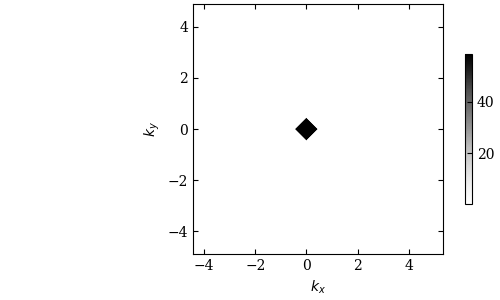

In [32]:
latt.plot_k(item['IsingZ_eqK'][0,0])

### Plot Spin-Spin correlation in disordered phase

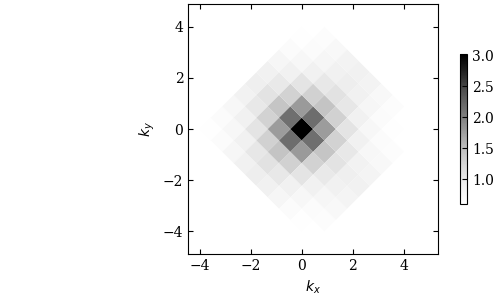

In [33]:
latt.plot_k(res.loc['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3']['IsingZ_eqK'][0,0])